In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

data_path = os.path.join(os.getcwd())

In [2]:
# get top 50 stocks by market cap
top_stocks = pd.read_csv(os.path.join(data_path, 'top50stocks.csv'))
top_stocks.head()

,rank,name,symbol,market_cap
0,1,APPLE INC.,AAPL,2525.11
1,2,MICROSOFT CORPORATION,MSFT,2099.65
2,3,ALPHABET INC.,GOOG,1724.81
3,4,"AMAZON.COM, INC.",AMZN,1480.99
4,5,"TESLA, INC.",TSLA,822.00


In [3]:
from sklearn.preprocessing import MinMaxScaler

def get_stock_data(symbol, folder='Stocks'):
    """
    Gets stock data from Kaggle files
    """
    df = pd.read_csv(os.path.join(data_path,
                        folder, f"{symbol}.us.txt"), index_col="Date", parse_dates=True)
    return df

transformers = {}

def get_scaled_data(symbol, folder='Stocks'):
    """
    Gets scaled data from from a symbol
    """

    df = get_stock_data(symbol, folder)

    scaler = MinMaxScaler(feature_range=(0, 1))
    if 'OpenInt' in df.columns:
        df = df.drop('OpenInt', axis=1)
    scaled_data = scaler.fit_transform(df)

    cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    return scaler, scaled_data, cols


In [17]:
#import train test split
from sklearn.model_selection import train_test_split

def get_model_data(symbol, folder='Stocks'):
    """
    Gets scaled data from from a symbol
    """

    scaler, scaled_data, cols = get_scaled_data(symbol, folder=folder)

    diff = 30
    pred_diff = 1

    X = []
    y = []

    # get train test split
    for i in range(diff, len(scaled_data) - pred_diff):
        # print("Getting x and y")
        # print(f"x = [{i - diff}:{i}]")
        # print(f"y = [{i}:{i + pred_diff}]")
        X.append(scaled_data[i - diff:i].reshape(1, diff, 5))
        y.append(scaled_data[i:i+pred_diff].reshape(1, 5))

    # don't shuffle to train on historical data
    return train_test_split(X, y, test_size=0.3)

X_train, X_test, y_train, y_test = get_model_data('aapl')
# X_train[0][0]

In [28]:
def show_graph(x, y, attr=0):
    # print(x)
    # print(y)
    # print(np.concatenate((x[attr], [y[attr]])))
    plt.plot(range(len(x[:, attr])+1), np.concatenate((x[:, attr], [y[attr]])))
    plt.show()

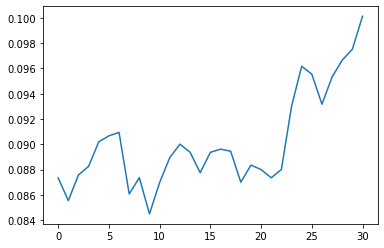

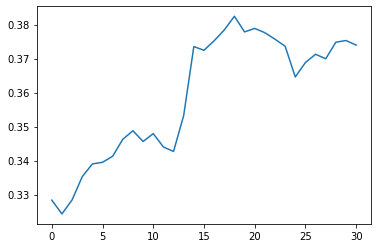

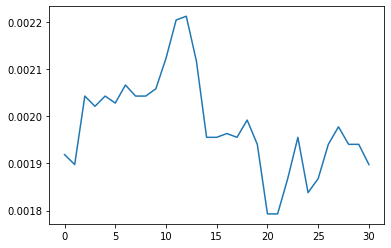

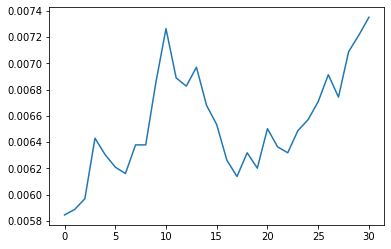

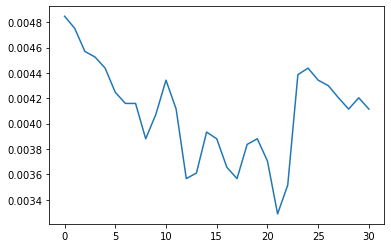

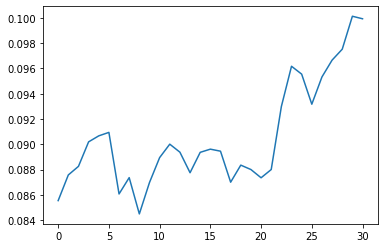

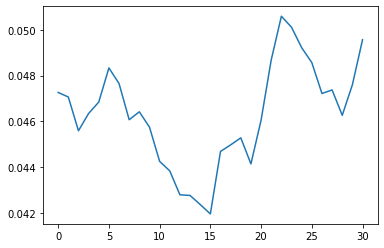

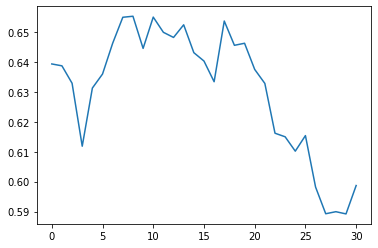

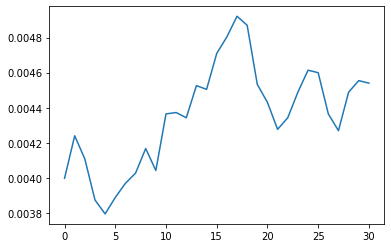

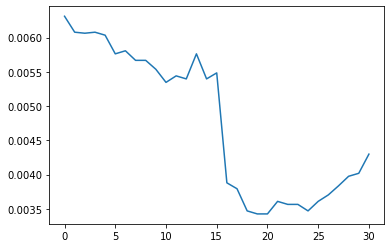

In [29]:
for i in range(10):
    show_graph(X_train[i][0], y_train[i][0])

In [46]:
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Flatten, Dense, Activation, BatchNormalization, MaxPool1D, LSTM, AveragePooling1D
from tensorflow import keras

In [47]:
input_shape = X_train[0].shape
input_shape

(1, 30, 5)

In [61]:
model = Sequential()

# 20 days of data ("month" of data)
# 5 day work week
# 4 weeks = 28 days ~or~ 20 days of being open
model.add(Conv1D(
    filters=128,
    kernel_size=2,
    activation='relu',
    input_shape=(input_shape[1], input_shape[2]),
    padding='same',
    data_format='channels_first',
    use_bias=True,
    kernel_initializer='variance_scaling'
))
model.add(AveragePooling1D(pool_size=2))
model.add(Dropout(0.25))

# 5 days of data (work week)
# model.add(Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same', data_format='channels_last'))
# model.add(MaxPool2D(pool_size=(2, 2), data_format='channels_last'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Flatten())
model.add(LSTM(256, activation='relu'))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5, activation='relu'))

In [65]:
model.compile(optimizer='sgd', loss='mse' , metrics=['mean_squared_error'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 128, 5)            7808      
                                                                 
 average_pooling1d_3 (Averag  (None, 64, 5)            0         
 ePooling1D)                                                     
                                                                 
 dropout_24 (Dropout)        (None, 64, 5)             0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               268288    
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 flatten_8 (Flatten)         (None, 256)               0         
                                                      

In [63]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10) # https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='mean_squared_error',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [64]:
import tensorflow as tf
epochs=50
batch_size=256

data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

history = model.fit(
    data,
    batch_size=batch_size,
    epochs=epochs, # number of times to iterate over the data before validation
    validation_data=test_data, # data the model has never been trained on
    callbacks=callbacks # list of callbacks to apply during training (after or during each epoch)
)

Epoch 1/50


ValueError: in user code:

    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py", line 817, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 439, in update_state
        self.build(y_pred, y_true)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 359, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 485, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 485, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 504, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\metrics.py", line 3785, in get
        return deserialize(str(identifier))
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\metrics.py", line 3741, in deserialize
        return deserialize_keras_object(
    File "C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py", line 708, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: root_mean_squared_error. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


In [ ]:
stocks = list(top_stocks['symbol'])

for s in top_stocks.iterrows():
    # lowercase symbol
    symbol = s[1]['symbol'].lower()
    # get data
    df = pd.read_csv(os.path.join(data_path, 'Stocks', symbol + '.us.txt'))
    # print(symbol.upper())
    # print(df.head())


In [ ]:
def get_list_of_etfs():
    etf_dir = os.listdir(os.path.join(data_path, "ETFs"))
    etf_list = [x.split(".")[0] for x in etf_dir]
    return etf_list

get_list_of_etfs()

In [73]:
etfs = {}
etfs_list = get_list_of_etfs()

for i in etfs_list:
    etfs[i] = get_scaled_data(i, folder='ETFs')


In [78]:
def get_date_list(df):
    """
    Gets list of dates
    """
    date_list = set()
    for i in etfs_list:
        for d in df[i].index:
            date_list.add(d)
    return date_list


In [93]:
df = pd.DataFrame(columns=etfs_list, index=get_date_list(etfs))

In [109]:
from multiprocessing.pool import ThreadPool as Pool

pool_size = 10
pool = Pool(pool_size)

results = []

def add_to_df(etf):
    df[etf] = etfs[etf]["Close"]

for etf in etfs_list:
    res = pool.apply_async(add_to_df(etf))
    results.append(res)


In [108]:
df.head()

,aadr,aaxj,acim,actx,acwf,acwi,acwv,acwx,adra,adrd,...,yinn,ylco,ymli,ymlp,yxi,yyy,ziv,zmlp,zroz,zsl
2005-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.315858,0.461296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-03,NaN,0.182917,NaN,NaN,NaN,0.113054,NaN,0.179618,0.171514,0.157235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.427591
2012-04-05,NaN,0.536197,NaN,NaN,NaN,0.409909,0.133574,0.512003,0.429158,0.379532,...,0.224738,NaN,NaN,0.805381,0.613422,NaN,0.072738,NaN,0.367268,0.002763
2009-02-03,NaN,0.091765,NaN,NaN,NaN,0.093051,NaN,0.135167,0.103917,0.147855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.487314
2012-10-31,0.144763,0.541342,NaN,NaN,NaN,0.422611,0.192753,0.526529,0.388731,0.413182,...,0.129993,NaN,NaN,0.822724,0.540086,0.29257,0.154215,NaN,0.526834,0.001153


In [110]:
len(df.columns)

1344

In [111]:
def get_date_range(start, end):
    """
    Gets date range from start to end from df
    """
    if type(start) == str:
        start = pd.to_datetime(start)
        
    if type(end) == str:
        end = pd.to_datetime(end)

    return df.between_time(start, end)


In [113]:
df.to_numpy()

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan, 0.18291732,        nan, ...,        nan,        nan,
        0.42759077],
       [       nan, 0.53619716,        nan, ...,        nan, 0.36726792,
        0.00276311],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.44919383, 0.76600921, 0.61658058, ..., 0.70195178, 0.63234606,
        0.01154533],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

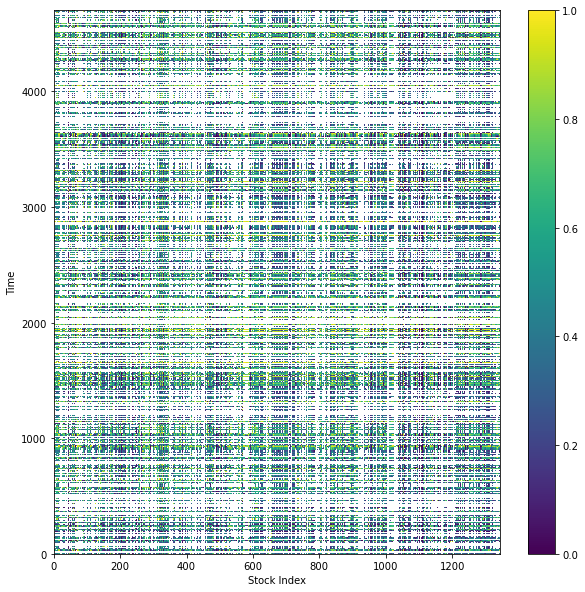

In [124]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(df, cmap='viridis')
plt.xlabel('Stock Index')
plt.ylabel('Time')
plt.colorbar()

## Dealing with NaN

In [127]:
from datetime import datetime
plt.figure(figsize=(10, 10))
plt.pcolormesh(get_date_range(datetime.strptime('2010-01-01', '%Y-%m-%d'), '2020-01-01'), cmap='viridis')
plt.xlabel('Stock Index')
plt.ylabel('Time')
plt.colorbar()

TypeError: strptime() takes exactly 2 arguments (1 given)

<Figure size 720x720 with 0 Axes>